# Imports

In [15]:
# !git commit -m "change project structure and research design"

# %cd ..
!git push

Enumerating objects: 38, done.
Counting objects: 100% (38/38), done.
Delta compression using up to 4 threads
Compressing objects: 100% (32/32), done.
Writing objects: 100% (34/34), 123.39 MiB | 5.94 MiB/s, done.
Total 34 (delta 8), reused 1 (delta 0)
remote: 
remote: To create a merge request for anomaly_detection, visit:
remote:   https://gitlab.com/Nuc1eonCyb3r/data-science/nabu/-/merge_requests/new?merge_request%5Bsource_branch%5D=anomaly_detection
remote: 
To gitlab.com:Nuc1eonCyb3r/data-science/nabu.git
   f35190f..9eaa58e  anomaly_detection -> anomaly_detection


In [17]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 365 bytes | 365.00 KiB/s, done.
From gitlab.com:Nuc1eonCyb3r/data-science/nabu
   9eaa58e..518e549  anomaly_detection -> origin/anomaly_detection
Updating 9eaa58e..518e549
Fast-forward
 .gitignore | 2 ++
 1 file changed, 2 insertions(+)


In [1]:
%%bash
pip install wheel pandas matplotlib plotly wandb autohash 
export WANDB_NOTEBOOK_NAME='Auto-Encoders-v1'

In [20]:
!pip install tensorflow==2.6.0

  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, losses, callbacks, Sequential, optimizers, metrics
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook

In [2]:
import sys
module_path = sys.path.append('/home/ubuntu/nabu/anomaly_detection/src')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import *
from helpers import *

In [3]:
RANDOM_SEED = 0

set_seed(RANDOM_SEED)

In [4]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project='AutoEncoder', entity='anomaly-idc')

# Data Preprocessing

In [6]:
DATA = Path('../data')
TRAIN_DATASET = DATA / 'train_data_new.csv'
TEST_DATASET = DATA / 'test_data_new.csv'

df_train = pd.read_csv(TRAIN_DATASET.resolve())
df_test = pd.read_csv(TEST_DATASET.resolve())

In [7]:
df_train

,_id,session_id,sensor_id,port,ip,ts,country,tor,packet_size,identify,...,DE,GB,IN,JP,NL,OM,RU,SG,US,time_val
0,60e3347be9809b72a5b0d334,ec892c1a-e1cc-45ea-8040-ced7bef29d87,365,6,111122172149,2021-07-05 16:34:03.312000+00:00,2,0,52.0,0,...,0,0,0,0,0,0,0,0,0,16
1,60e3347be9809b72a5b0d335,45827df4-fc6c-42c3-b8a8-07ca7c39fee6,5,1,59125225176,2021-07-05 16:34:03.367000+00:00,35,0,43.0,0,...,0,0,0,0,0,0,0,0,0,16
2,60e3347be9809b72a5b0d336,d8b6b5bf-fead-483c-b205-b1ba082661c8,5,1,45146167035,2021-07-05 16:34:03.423000+00:00,6,0,43.0,0,...,0,0,0,0,0,0,1,0,0,16
3,60e3347be9809b72a5b0d337,01c99580-ca72-43a0-9b8e-27c2560543a0,5,1,185219052083,2021-07-05 16:34:03.478000+00:00,21,0,43.0,0,...,0,0,0,0,0,0,0,0,0,16
4,60e3347be9809b72a5b0d338,bc2b1527-6edf-48f1-9b9a-3d5129c698c7,5,1,62094072008,2021-07-05 16:34:03.536000+00:00,28,0,43.0,0,...,0,0,0,0,0,0,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365974,6104877c9a69d6a203d9c7f9,b462282e-df3c-4bf1-ac7a-528753d6ce41,54,1,218094034054,2021-07-30 23:13:00.011000+00:00,2,0,46.0,0,...,0,0,0,0,0,0,0,0,0,119
1365975,6104877d9a69d6a203d9c7fa,06533f11-f760-40be-b861-393e84ea44d9,253,3,71006199023,2021-07-30 23:13:01.040000+00:00,1,0,252.0,0,...,0,0,0,0,0,0,0,0,1,119
1365976,6104877e9a69d6a203d9c7fb,aa4d5d02-6c48-4324-b346-975953f73e15,9,1,175101006210,2021-07-30 23:13:02.077000+00:00,3,0,43.0,0,...,0,0,1,0,0,0,0,0,0,119
1365977,610487819a69d6a203d9c7fc,f7913416-2c06-49f8-a9f6-2269bf26f9c1,6,1,218094034054,2021-07-30 23:13:05.227000+00:00,2,0,42.0,0,...,0,0,0,0,0,0,0,0,0,119


In [8]:
df_test

,_id,session_id,sensor_id,port,ip,ts,country,tor,packet_size,identify,...,DE,GB,IN,JP,NL,OM,RU,SG,US,time_val
0,6104928c9a69d6a203d9cbd1,f418b705-f621-47d1-a26f-552eefde2bd7,1,1,150095088177,2021-07-31 00:00:12.677000+00:00,7,0,43.0,0,...,0,0,0,0,0,0,0,1,0,120
1,6104928d9a69d6a203d9cbd2,27a4ae9c-99d6-467c-b2a4-a1c6fa4dfc6f,159,4,162142125038,2021-07-31 00:00:13.714000+00:00,1,0,128.0,0,...,0,0,0,0,0,0,0,0,1,120
2,6104928f9a69d6a203d9cbd3,21936f12-f37a-416c-bb53-fe342c007e03,2,1,20084049161,2021-07-31 00:00:15.799000+00:00,1,0,43.0,0,...,0,0,0,0,0,0,0,0,1,120
3,610492909a69d6a203d9cbd4,8c1fa901-fac4-4bde-97cc-8e1a5074e2bd,159,4,162142125038,2021-07-31 00:00:16.821000+00:00,1,0,39.0,0,...,0,0,0,0,0,0,0,0,1,120
4,610492909a69d6a203d9cbd5,214385fd-f32e-48da-9008-f38f378c8d70,85,1,14128032062,2021-07-31 00:00:16.835000+00:00,7,0,43.0,0,...,0,0,0,0,0,0,0,1,0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282920,610804a2f7368742c471a445,3a551a24-3f5a-4186-8663-aecaa760e941,2,1,143198184062,2021-08-02 14:43:46.687000+00:00,1,0,43.0,0,...,0,0,0,0,0,0,0,0,1,14
282921,610804a3f7368742c471a446,cac661ef-7bfd-4b1f-af38-0415bea9002c,4,1,143198184062,2021-08-02 14:43:47.742000+00:00,1,0,43.0,0,...,0,0,0,0,0,0,0,0,1,14
282922,610804a3f7368742c471a447,4f1988be-805f-4c1b-a118-2e547690ec38,9,1,143198184062,2021-08-02 14:43:47.789000+00:00,1,0,43.0,0,...,0,0,0,0,0,0,0,0,1,14
282923,610804a3f7368742c471a448,3f11ab2e-796f-4fe2-9141-0f3516643a52,3,1,143198184062,2021-08-02 14:43:47.855000+00:00,1,0,43.0,0,...,0,0,0,0,0,0,0,0,1,14


In [9]:
# dropping redundant columns
redundant_columns = ['_id', 'port', 'ip', 'ts']
df_train_selected = df_train.drop(columns=redundant_columns, axis=1)
df_test_selected = df_test.drop(columns=redundant_columns, axis=1)

In [10]:
SELECTED_FEATURES = [
    'packet_size',
    'country',
    'ip',
    'sensor_id', 
    'time_val', 
    'tor', 
    'agg_session_id_row_count',
    'agg_session_id_packet_size_sum',
    'agg_session_id_packet_size_max'
]
label = ['identify']

## Undersampling

In [191]:
RATIO_TO_MALICIOUS = 15

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(mal) * RATIO_TO_MALICIOUS),
    random_state=RANDOM_SEED
)

In [15]:
# concatenate clean undersampled with malicious packets
visualisation_initial = pd.concat([mal, clean_undersampled])
column_names = list(visualisation_initial.drop(columns=['identify'], axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop(columns=['identify'], axis=1).values, \
                   visualisation_initial.identify.values

In [54]:
print(
    f"""
    The non-malicious dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
    This represents a ratio of {RATIO_TO_MALICIOUS}:1 to malicious.""")


    The non-malicious dataset has been undersampled from 1,647,829 to 16,125.
    This represents a ratio of 15:1 to malicious.


In [56]:
from sklearn.manifold import TSNE

# t-SNE dimensionality reduction
features_embedded = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(features)

In [62]:
results = pd.DataFrame()
results['label'] = labels
results['tsne-2d-one'] = features_embedded[:,0]
results['tsne-2d-two'] = features_embedded[:,1]

<Figure size 1152x720 with 0 Axes>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

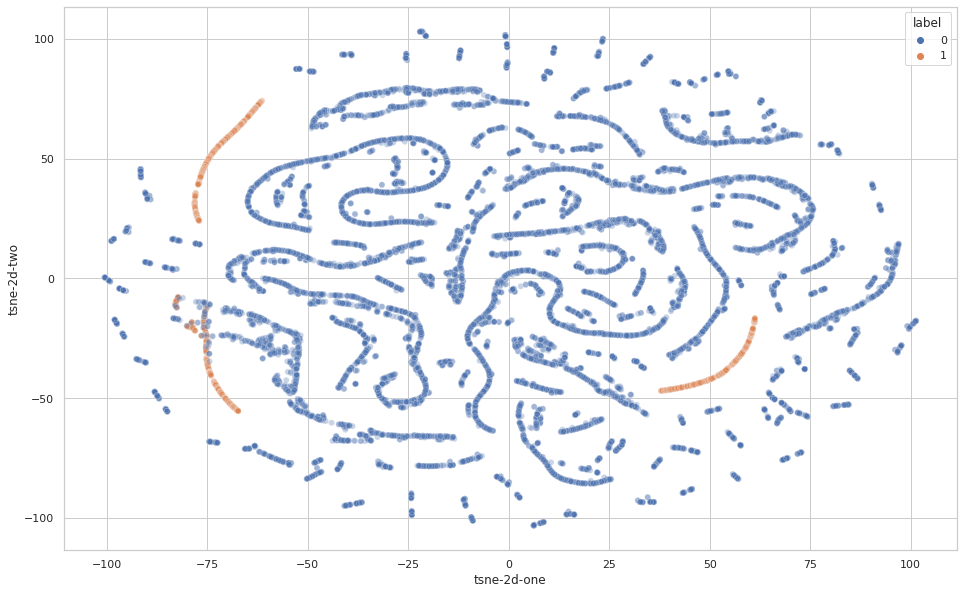

In [76]:
%matplotlib inline
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    data=results,
    legend="full",
    alpha=0.3
)
plt.show()

## Split (Train/Validation/Test)

In [77]:
print(f"""Shape of the datasets (rows, cols):
    clean     = {clean.shape}
    malicious = {mal.shape}""")

Shape of the datasets (rows, cols):
    clean     = (1647829, 55)
    malicious = (1075, 55)


In [16]:
clean.columns

Index(['session_id', 'sensor_id', 'country', 'packet_size', 'identify',
       'accum_packet_size', 'accum_count_by_ip', 'ip_bit_0', 'ip_bit_1',
       'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6', 'ip_bit_7',
       'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11', 'ip_bit_12',
       'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16', 'ip_bit_17',
       'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21', 'ip_bit_22',
       'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26', 'ip_bit_27',
       'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31', 'port_bit_0',
       'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4', 'port_bit_5',
       'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9', 'port_bit_10',
       'port_bit_11', 'port_bit_12', 'port_bit_13', 'port_bit_14',
       'port_bit_15'],
      dtype='object')

In [16]:
TRAINING_SAMPLE = 1_600_000

# shuffle our training set
clean_shuffle = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean_shuffle.iloc[:TRAINING_SAMPLE].drop('identify', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean_shuffle.iloc[TRAINING_SAMPLE:].append(mal).sample(frac=1)

In [17]:
print(f"""Testing set: 
{X_test.identify.value_counts()}""")

Testing set: 
0    47829
1     1075
Name: identify, dtype: int64


In [18]:
VALIDATE_SIZE = 0.2

X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

X_test, y_test = X_test.drop('identify', axis=1).values, X_test.identify.values

## Normalize and Scale

In [11]:
X_train_tmp = df_train[df_train.identify==0][SELECTED_FEATURES]
y_train_tmp = df_train[label]

In [12]:
TRAINING_SAMPLE = 1_000_000

X_train = X_train_tmp.iloc[:TRAINING_SAMPLE]
y_train = y_train_tmp.iloc[:TRAINING_SAMPLE]

X_val = X_train_tmp.iloc[TRAINING_SAMPLE:]
y_val = y_train_tmp.iloc[TRAINING_SAMPLE:]

In [13]:
X_test = df_test[SELECTED_FEATURES]
y_test = df_test[label]

In [14]:
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [15]:
pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [16]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_val)

In [17]:
X_train_transformed.shape

(1000000, 9)

# Model

In [18]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256

In [39]:
class AutoEncoders(Model):
    def __init__(self, input_dim,  architecture: list, name="autoencoder", **kwargs):
        super(AutoEncoders, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.encoder = [layers.Dense(architecture[0], activation="elu", input_shape=(input_dim,))] + [layers.Dense(dim, activation="elu") for dim in architecture[1:]]
        self.decoder = [layers.Dense(dim, activation="elu") for dim in architecture[::-1][1:]]
        
    def call(self, x):
        # encoder
        for l in self.encoder:
            x = l(x)
        # decoder
        for l in self.decoder:
            x = l(x)
        return x
    
    def mad_score(self, points):
        """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
        m = np.median(points)
        ad = np.abs(points - m)
        mad = np.median(ad)

        return 0.6745 * ad / mad
    
    def get_outliers(self, x, threshold: float=3.5):
        reconstructions = self.predict(x)
        mse = np.mean(np.power(x - reconstructions, 2), axis=1)
        z_scores = self.mad_score(mse)
        return z_scores > threshold

In [55]:
autoencoder = AutoEncoders(input_dim=input_dim, architecture=[input_dim, 16, 8 ,4 ,2])

In [60]:
autoencoder.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3),  # try `RMSprop`
                    loss=metrics.mean_squared_error,
                    metrics=["acc"])

In [61]:
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

config = wandb.config
# config.learning_rate = 0.01

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.tf',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

cb = [early_stop, save_model]# , WandbCallback(save_format="tf")]

# Training

In [62]:
EPOCHS = 100

In [63]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
)

Epoch 1/100
3907/3907 [==============================] - 6s 1ms/step - loss: 7.6962e-04 - acc: 0.9988 - val_loss: 9.7723e-05 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
3907/3907 [==============================] - 5s 1ms/step - loss: 1.1882e-04 - acc: 0.9999 - val_loss: 6.2081e-05 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
3907/3907 [==============================] - 5s 1ms/step - loss: 9.2320e-05 - acc: 0.9999 - val_loss: 6.8616e-05 - val_acc: 0.9999
Epoch 4/100
3907/3907 [==============================] - 5s 1ms/step - loss: 7.1296e-05 - acc: 0.9999 - val_loss: 4.4509e-05 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 5/100
3907/3907 [==============================] - 5s 1ms/step - loss: 5.7367e-05 - acc: 0.9999 - val_loss: 2.0978e-05 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch

In [64]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  90        
_________________________________________________________________
dense_1 (Dense)              multiple                  160       
_________________________________________________________________
dense_2 (Dense)              multiple                  136       
_________________________________________________________________
dense_3 (Dense)              multiple                  36        
_________________________________________________________________
dense_4 (Dense)              multiple                  10        
_________________________________________________________________
dense_5 (Dense)              multiple                  12        
_________________________________________________________________
dense_6 (Dense)              multiple                  

In [143]:
reconstructions_train = autoencoder.predict(X_train_transformed) 

In [144]:
mse_train = np.mean(np.power(X_train_transformed - reconstructions_train, 2), axis=1)
mse.shape

(282925,)

In [145]:
X_test_transformed = pipeline.transform(X_test)
reconstructions_test = autoencoder.predict(X_test_transformed)

In [146]:
mse_test = np.mean(np.power(X_test_transformed - reconstructions_test, 2), axis=1)
mse_test.shape

(282925,)

In [228]:
clean = mse[y_test.identify.astype(int).values ==0]
mal = mse[y_test.identify.astype(int).values ==1]

(array([6.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.36, 7.52, 7.68, 7.84, 8.  ]),
 <BarContainer object of 50 artists>)

(array([6.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.36, 7.52, 7.68, 7.84, 8.  ]),
 <BarContainer object of 50 artists>)

Text(0.5, 1.0, '(Normalized) Distribution of the Reconstruction Loss')

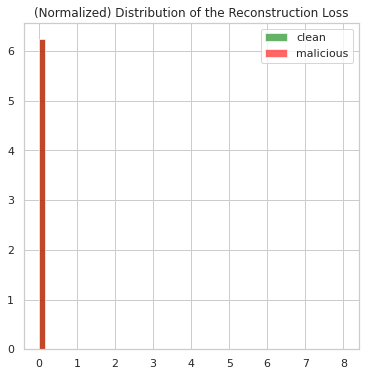

In [230]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green", range=[0, 8], align='mid')
ax.hist(mal, bins=50, density=True, label="malicious", alpha=.6, color="red", range=[0, 8], align='mid')

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [149]:
from sklearn.cluster import KMeans

KMeans_model = KMeans(n_clusters=2)
kmean = KMeans_model.fit(mse_train.reshape(-1, 1))

In [150]:
res = kmean.predict(mse_test.reshape(-1, 1))

In [151]:
(res[res]==1).sum()

0

In [152]:
(kmean.labels_ == 1).sum()

174

In [160]:
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

In [257]:
THRESHOLD = 3.5

z_scores = mad_score(mse_test)
outliers = z_scores > THRESHOLD

In [258]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 30,740 outliers in a total of 282,925 transactions [10.87%].


In [259]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()


In [260]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as malicious that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of malicious transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3.5 are as follows:
[[252182  30669]
 [     3     71]]

% of transactions labeled as malicious that were correct (precision): 71/(30669+71) = 0.23%
% of malicious transactions were caught succesfully (recall):    71/(3+71) = 95.95%


In [261]:
# get metrics
fpr, tpr, auc_score = get_auc(y_test, outliers)
precision, recall, aucpr_score = get_aucpr(y_test, outliers)

In [262]:
fpr, tpr

(array([0.        , 0.10842811, 1.        ]),
 array([0.        , 0.95945946, 1.        ]))

In [265]:
precision, recall

(array([2.61553415e-04, 2.30969421e-03, 1.00000000e+00]),
 array([1.        , 0.95945946, 0.        ]))

In [263]:
auc_score

0.9255156735658836

In [264]:
aucpr_score

0.4806283251776797

In [254]:
clean = z_scores[y_test.identify.astype(int).values ==0]
mal = z_scores[y_test.identify.astype(int).values ==1]

(array([1.65668637e+00, 9.82548159e-01, 5.34538842e-01, 1.87148601e-01,
        1.57193304e-01, 3.69016621e-01, 9.52568859e-01, 1.01219142e-01,
        4.55570149e-02, 1.96581640e-02, 5.64062092e-02, 1.70178733e-02,
        1.68498548e-02, 2.27545048e-02, 1.84340292e-02, 2.05942670e-02,
        2.19864203e-02, 1.91061032e-02, 6.22388513e-02, 3.70624798e-01,
        3.45830069e-01, 8.61214803e-02, 5.76303439e-02, 4.79572791e-02,
        2.29705286e-02, 6.67273453e-03, 5.08856015e-03, 3.79241747e-03,
        3.14434613e-03, 3.79241747e-03, 3.36036991e-03, 2.20824308e-03,
        1.84820345e-03, 1.99221930e-03, 1.96821666e-03, 1.32014532e-03,
        1.84820345e-03, 2.04022459e-03, 7.20079266e-04, 7.44081909e-04,
        9.84108331e-04, 6.48071340e-04, 5.76063413e-04, 4.08044918e-04,
        4.56050202e-04, 5.52060771e-04, 7.68084551e-04, 2.47227215e-03,
        4.48849409e-03, 5.44859978e-03]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 

(array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 2.34375,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.78125, 0.     , 0.78125, 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.78125,
        0.     , 0.78125, 0.78125, 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     ]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.36, 7.52, 7.68, 7.84, 8.  ]),
 <BarContainer object of 50 artists>)

Text(0.5, 1.0, 'Distribution of the modified z-scores')

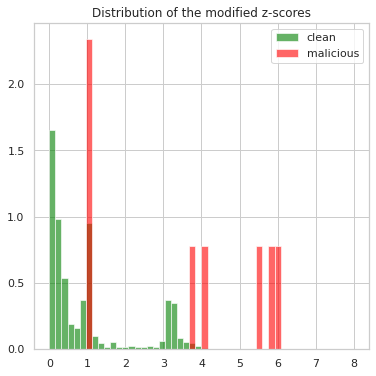

In [255]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green", range=[0, 8], align='mid')
ax.hist(mal, bins=50, density=True, label="malicious", alpha=.6, color="red", range=[0, 8], align='mid')

plt.savefig('z_score_dist_threshold_3_5.png')
plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [188]:
encoder = tf.keras.models.Sequential(autoencoder.encoder)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                160       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
Total params: 432
Trainable params: 432
Non-trainable params: 0
_________________________________________________________________


In [192]:
# taking all the fraud, undersampling clean
mal = X_test_transformed[y_test.identify.astype(int).values ==1]
clean = X_test_transformed[y_test.identify.astype(int).values ==0][:len(mal) * RATIO_TO_MALICIOUS, ]

In [193]:
# combining arrays & building labels
features = np.append(mal, clean, axis=0)
labels = np.append(np.ones(len(mal)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test.identify.astype(int).values ==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

Clean transactions downsampled from 282,851 to 1,110.
Shape of latent representation: (1184, 2)


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 1.0, 'Latent Space Representation')

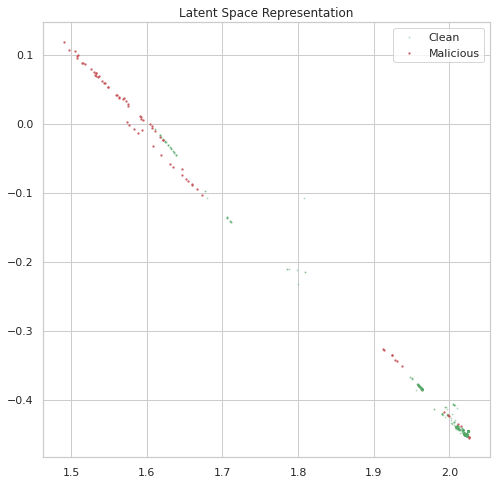

In [195]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Malicious')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d')
plt.show()